In [127]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import requests
from bs4 import BeautifulSoup

In [128]:
# 그래프 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [129]:
# 네이버 API 인증 정보
client_id = 'YaKyDrFyIZDRfIiRAwBj'
client_secret = 'hknmr5WHGm'

In [130]:
# 업비트 데이터를 가져오는 함수
def fetch_upbit_data(market="KRW-BTC", count=200):
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market, "count": count}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"업비트 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.sort_values(by="date", inplace=True)
    return df

In [131]:
# 뉴스 데이터를 가져오는 함수
def fetch_news_data(query, display=10):
    url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display={display}"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"뉴스 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    return pd.DataFrame(data['items'])

In [132]:
# KoBERT 감정 분석을 위한 함수
def analyze_sentiment_with_kobert(texts):
    tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")
    model = AutoModelForSequenceClassification.from_pretrained("beomi/kcbert-base")
    sentiments = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        # KoBERT에서는 token_type_ids를 제외
        inputs.pop("token_type_ids", None)
        outputs = model(**inputs)
        sentiment = torch.argmax(outputs.logits, dim=1).item()  # 감정 점수 계산
        sentiments.append(sentiment)

    return sentiments

In [133]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

# SSL 인증 경고를 무시하도록 설정
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

def crawl_additional_news(url):
    # SSL 인증을 무시하고 GET 요청을 보냄
    response = requests.get(url, verify=False)
    
    if response.status_code != 200:
        print(f"뉴스 크롤링 실패: 상태 코드 {response.status_code}")
        return None, None

    # 크롤링 로직 처리
    soup = BeautifulSoup(response.text, "html.parser")
    
    # 뉴스 제목 크롤링
    title_tag = soup.find("h1")  # 실제 태그와 클래스명을 확인 후 수정
    title = title_tag.text.strip() if title_tag else "제목 없음"
    
    # 뉴스 본문 크롤링
    content_tag = soup.find("div", class_="content")  # 실제 태그와 클래스명을 확인 후 수정
    content = content_tag.text.strip() if content_tag else "본문 없음"
    
    return title, content

In [134]:
# BTC/KRW 시장 데이터 가져오기
df_price = fetch_upbit_data()
if df_price is None:
    raise ValueError("업비트 데이터를 가져오지 못했습니다.")

In [135]:
# 뉴스 데이터 가져오기
news_df = fetch_news_data("비트코인")
if news_df is None:
    raise ValueError("뉴스 데이터를 가져오지 못했습니다.")

In [136]:
# 뉴스 데이터 날짜별 처리
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')
news_df['date'] = news_df['pubDate'].dt.date
news_df = news_df.dropna(subset=['date'])

In [137]:
# KoBERT로 감정 분석 수행
news_df['sentiment'] = analyze_sentiment_with_kobert(news_df['title'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [138]:
# 크롤링할 뉴스 URL 리스트

news_urls = [
    "https://www.g-enews.com/ko-kr/news/article/news_all/202312031530096281e7e8286d56_1/article.html",
    "https://www.yna.co.kr/view/AKR20231007023200002?input=1195m",
    "https://www.hankyung.com/article/2023100952301",
    "https://www.news1.kr/finance/general-finance/5193940",
    "https://www.sisajournal-e.com/news/articleView.html?idxno=304014",
    "https://view.asiae.co.kr/article/2023100813494835117",
]

In [139]:
# 추가 뉴스 크롤링 및 데이터 추가
for url in news_urls:
    additional_title, additional_content = crawl_additional_news(url)
    if additional_title:
        additional_sentiment = analyze_sentiment_with_kobert([additional_title])[0]
        print(f"추가 뉴스 제목: {additional_title}")
        print(f"추가 뉴스 감정 점수: {additional_sentiment}")
        news_df = pd.concat([news_df, pd.DataFrame({
            "date": [pd.to_datetime("2023-12-03").date()],
            "title": [additional_title],
            "sentiment": [additional_sentiment]
        })], ignore_index=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


추가 뉴스 제목: 일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까
추가 뉴스 감정 점수: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


추가 뉴스 제목: 상반기 국내 가상자산 시총 28조…비트코인 등 회복세에 46%↑
추가 뉴스 감정 점수: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


추가 뉴스 제목: 금융
추가 뉴스 감정 점수: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


추가 뉴스 제목: 이스라엘 전쟁에도 올랐던 비트코인, 상승분 반납…3750만원대[코인브리핑]
추가 뉴스 감정 점수: 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


추가 뉴스 제목: [Weekly Coin] 미 고용지표도 넘은 비트코인···반등 성공
추가 뉴스 감정 점수: 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


추가 뉴스 제목: [비트코인 지금]美 고용 급증에도 상승세…금리 인상 신중론 강화
추가 뉴스 감정 점수: 1


In [140]:
# 날짜별 평균 감정 점수 계산
sentiment_by_date = news_df.groupby('date')['sentiment'].mean().reset_index()
sentiment_by_date.columns = ['date', 'average_sentiment']

In [141]:
# 감정 점수 병합
merged_df = pd.merge(df_price, sentiment_by_date, on='date', how='left')
merged_df['average_sentiment'].fillna(2.5, inplace=True)

C:\Users\kgg07\AppData\Local\Temp\ipykernel_16992\731998398.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['average_sentiment'].fillna(2.5, inplace=True)


In [142]:
# 데이터 스케일링
price_scaler = MinMaxScaler()
sentiment_scaler = MinMaxScaler()

In [143]:
merged_df['scaled_price'] = price_scaler.fit_transform(merged_df['price'].values.reshape(-1, 1))
merged_df['scaled_sentiment'] = sentiment_scaler.fit_transform(merged_df['average_sentiment'].values.reshape(-1, 1))

In [144]:
# 멀티모달 데이터 생성 함수
def create_multimodal_sequences(prices, sentiments, seq_length):
    sequences = []
    labels = []
    for i in range(len(prices) - seq_length):
        seq = np.column_stack((prices[i:i + seq_length], sentiments[i:i + seq_length]))
        label = prices[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [145]:
# 멀티모달 데이터 준비
sequence_length = 10
X, y = create_multimodal_sequences(
    merged_df['scaled_price'].values,
    merged_df['scaled_sentiment'].values,
    sequence_length
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
# GRU 모델 생성
model = Sequential([
    GRU(128, input_shape=(sequence_length, 2), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

C:\Users\kgg07\anaconda3\envs\learning3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [147]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0562 - val_loss: 0.0108
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0134 - val_loss: 0.0052
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0101 - val_loss: 0.0070
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0070 - val_loss: 0.0032
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0087 - val_loss: 0.0027
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0058 - val_loss: 0.0027
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

In [148]:
# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = price_scaler.inverse_transform(predictions)
original_scale_y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step


In [149]:
# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

샘플 예측값과 실제값:
예측값: 136,081,008.00, 실제값: 128,783,000.00
예측값: 134,959,184.00, 실제값: 133,802,000.00
예측값: 84,354,096.00, 실제값: 84,631,000.00
예측값: 81,597,848.00, 실제값: 86,397,000.00
예측값: 77,504,168.00, 실제값: 80,930,000.00


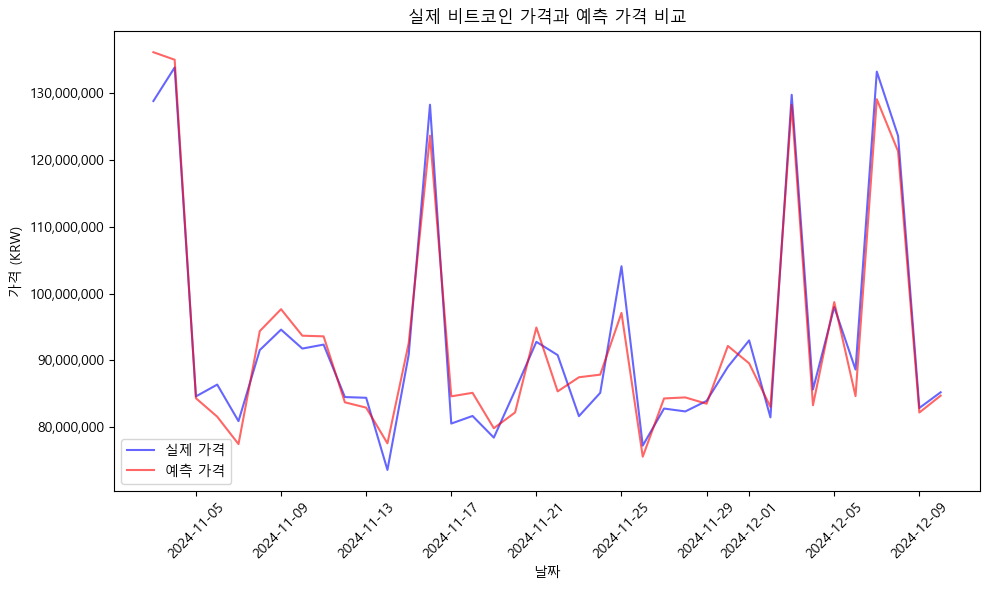

In [150]:
# 시각화
plt.figure(figsize=(10, 6))
plt.plot(merged_df['date'][-len(original_scale_y_test):], original_scale_y_test, label='실제 가격', color='blue', alpha=0.6)
plt.plot(merged_df['date'][-len(original_scale_predictions):], original_scale_predictions, label='예측 가격', color='red', alpha=0.6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('실제 비트코인 가격과 예측 가격 비교')
plt.xlabel('날짜')
plt.ylabel('가격 (KRW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()